In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

In [209]:
def write_to_csv(xx,yy,zz, filename, fieldnames = ['x','y','z']) :
    import csv
    
    with open(filename,'w') as csvfile :
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for x,y,z in zip(xx,yy,zz) :
            writer.writerow({fieldnames[0] : x, fieldnames[1] : y, fieldnames[2] : z})


In [2]:
import numpy as np
from scipy.special import erf
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

def phi(x) :
    return norm.pdf(x)

def Phi(x) :
    return norm.cdf(x)

def Haar(x, n, Amin = 0, Amax = 1) :
    #the n-th Haar like basis function on (Amin,Amax)
    def H0(x) :
        return 1.0*(x>0.5)*(x<1)
    
    y = 1.0 * x / (Amax - Amin) + float(Amin)/(Amin - Amax)
    shifts = np.expand_dims(range(2 ** n),1)
    res = H0(2**n*y-shifts).sum(0)
    return res * (Amax - Amin) + Amin

def HaarIntervals(n, offset = 0, Amin = 0, Amax = 1) :
    #returns the intervals that forms the n-th Haar detector
    #format: I_i = (a[i],b[i])
    
    delta = 2 ** -n
    aN = delta + np.arange(0,1-delta,2*delta)
    bN = 2*delta + np.arange(0,1,2*delta)
    #aN[0]-=1 #-inf
    bN[-1]+=1 #inf
    a = aN * (Amax - Amin) + Amin + offset
    b = bN * (Amax - Amin) + Amin + offset
    return np.expand_dims(a,1), np.expand_dims(b,1)
    
def HaarFromIntervals(x, a, b) :
    return ((x>=a)*(x<=b)).sum(0)

def randomPartitionFromHaar(m, Amin = 0, Amax = 1, n = 1) :
    delta = 1./m

    c = (np.random.rand(int(m))>0.5)

    a1 = np.linspace(0,1,m+1)[:-1]
    b1 = a1 + c * delta

    a = a1*(Amax-Amin) + Amin
    b = b1*(Amax-Amin) + Amin    
    return a, b


def randomPartitionFromHaar_multi(m, Amin = 0, Amax = 1, n = 1) :
    delta = 1./m
    c = (np.random.rand(n,m)>0.5)

    a = np.linspace(0,1,m+1)[:-1] + np.zeros_like(c)
    b = a + c * delta

    a = a*(Amax-Amin) + Amin
    b = b*(Amax-Amin) + Amin

    return a, b

def randomPartition(delta, Amin, Amax, var = 1) :
    #returns a random partition of the interval (Amin,Amax) with average length m
    a = []
    b = []
    w  = Amin
    while w < Amax :
        w += delta*np.random.rand()
        a.append(max(w,Amin))
        w += delta*np.random.rand()
        b.append(min(w,Amax))
    return np.array(a), np.array(b)

def randomPartition2(m,n) :
    #computes a set n random partition into m parts
    #maybe modify to return a single partition every call ?
    a = np.zeros((n,m))
    b = np.zeros((n,m))

    i = 0
    while i < n :
        random_numbers = np.sort(np.random.rand(2*m))
        random_numbers = np.insert(random_numbers,0,0)
        intervals = (Amax-Amin)*(random_numbers)+Amin
        j = 0
        while j < 2*m :
            a[i,j/2] = intervals[j]
            b[i,j/2] = intervals[j+1]
            j+=2

        random_numbers = np.sort(np.random.rand(2*m))
        random_numbers = np.append(random_numbers,1)
        intervals = (Amax-Amin)*(random_numbers)+Amin
        j = 0
        while j < 2*m :
            a[i+1,j/2] = intervals[j+1]
            b[i+1,j/2] = intervals[j+2]
            j+=2

        i+=2
    return a, b

def randomPartition3(n, m, Amin, Amax) :
    arr =  np.concatenate((np.ones((n,1))*Amin, Amin + (Amax-Amin)*np.sort(np.random.rand(n,m)), np.ones((n,1))*Amax ),1)
    a = arr.T[0::2].T
    b = arr.T[-1::-2][::-1].T
    return (a,b)

In [3]:
def OneBitDist(y, n, m, Amin, Amax) :
    #mean estimation from one-bit using an arbitrary detector and MAP estimator
    dx = 0.01/np.sqrt(n)
    xx = np.arange(Amin,Amax,dx)
    th_prior = (xx<Amax)*(xx>Amin)*1.0/(Amax-Amin)*dx
    i = 0
    th_hat = []
    while i < n :
        #plt.plot(xx,th_prior)
        #updae rule
        th_prior_old = th_prior
        
        #a, b = Haar_intervals(m ,Amin,Amax)
        #delta = (Amax-Amin)/m
        #a, b = randomPartition(delta, Amin, Amax)
        a, b = randomPartitionFromHaar(m, Amin, Amax)
        b[b>=Amax] += 5
        a[a<=Amin] -= 5
        
        M = 2*np.any((max(y[i],Amin)>=a) * (min(y[i],Amax)<=b))-1

        base = (Phi(b-np.expand_dims(xx,1))-Phi(a-np.expand_dims(xx,1))).sum(1)
        th_prior = th_prior*((M>0)* base + (M<0) * (1-base))
        an = 1./(th_prior.sum())
        th_prior = an*th_prior

        th_hat.append(xx[np.argmax(th_prior)])
        #print "m = {}".format(m)
        #print "M = {}".format(M)
        #print "y = {}".format(y[i])
    
        i = i + 1
    
    #th_hat = median(th_prior,xx)
    return np.array(th_hat)

def OneBitDist_log(y, m, Amin, Amax) :
    n = y.shape[0]
    dx = 0.01/np.sqrt(n)
    xx = np.arange(Amin,Amax,dx)
    th_prior = np.log((xx<Amax)*(xx>Amin)*1.0/(Amax-Amin)*dx)
    i = 0
    th_hat = []
    while i < n :
        #plt.plot(xx,th_prior)
        #updae rule
        th_prior_old = th_prior
        
        #a, b = randomPartition(delta, Amin, Amax)
        a, b = randomPartitionFromHaar(m, Amin, Amax)
        b[b>=Amax] += 5
        a[a<=Amin] -= 5
        
        M = 2*np.any((max(y[i],Amin)>=a) * (min(y[i],Amax)<=b))-1

        base = (Phi(b-np.expand_dims(xx,1))-Phi(a-np.expand_dims(xx,1))).sum(1)
        th_prior += np.log(((M>0)* base + (M<0) * (1-base)))
    
        th_hat.append(xx[np.argmax(th_prior)])
    
        i = i + 1
    
    #th_hat = median(th_prior,xx)
    return np.array(th_hat)


def OneBitThresholds(y, tt, sigma) :
    #returns ML estimator from thresholds located at places tt
    from scipy.optimize import minimize_scalar

    n = len(y)
    M = (y < tt) + .0 #one bit messages
    
    #log-likelihood function
    LL = lambda x: -(M * np.log(Phi((tt-x)/sigma )+1e-7) + (1-M) * np.log(1-Phi((tt-x)/sigma) + 1e-7)).sum(0) 
    
    th_hat = minimize_scalar(LL,bounds = (Amin,Amax)).x
    return th_hat


def OneBitThresholds_history(y, tt, sigma) :
    n = len(y)
    th_hat = np.zeros(n)
    for i in range(len(y)) :
        th_hat[i] = OneBitThresholds(y[:i+1], tt[:i+1], sigma)
    
    return th_hat


In [ ]:
#mean estimation from one-bit using an arbitrary detector and MAP estimator

Amin = 5
Amax = 5
sig  = 1
xx, dx = np.linspace(Amin,Amax,1021, retstep=True)
a,b = HaarIntervals(2, Amin = Amin, Amax = Amax)

n=10
#np.random.seed(0)

Amax = 5
Amin = -5

m = np.sqrt(n) / np.sqrt(2*np.pi* np.log2(n) )

th = 0.8*((Amax-Amin) * np.random.rand() + Amin)

x = np.sqrt(sig) * np.random.randn(n) + th  #samples
 
dx = 0.01/np.sqrt(n)
xx = np.arange(Amin,Amax,dx)
th_prior = np.log((xx<Amax)*(xx>Amin)*1.0/(Amax-Amin)*dx)
i = 0
th_hat = np.zeros_like(x)
sig = 0.1

m_max = np.floor(np.log2(np.sqrt(n)/sig))
n_vals = np.arange(1,n+1)
m_vals = np.round(np.linspace(1,np.floor(np.log2(np.sqrt(n)/sig)),n))
m_prev = 0

print "m_max = {}".format(m_max)

while i < n :
    #plt.plot(xx,th_prior)
    #updae rule
    th_prior_old = th_prior
    
    L = (m_vals == m_vals[i]).sum() #num of consecutive m's
    delta = (Amax-Amin) * 2 ** (-(m_vals[i]+1)) / L
    if m_vals[i] != m_prev :
        offset = -(L/2 -0.5) * delta 
        m_prev = m_vals[i]
    else :
        offset += delta
        
    a, b = HaarIntervals(m_vals[i], offset = offset, Amin = Amin, Amax = Amax)
    #dither = (2*np.random.rand()-1) / (Amax-Amin) * 2 ** (-(m_vals[i]+1))
    
    M = 2*np.any((np.maximum(x[i],Amin)>=a) * (np.minimum(x[i],Amax)<=b))-1
    base = (Phi((b-xx)/sig) - Phi((a-xx)/sig)).sum(0)
    th_prior += np.log(((M>0)* base + (M<0) * (1-base)))
    th_hat[i]=xx[np.argmax(th_prior)]
    
    
    #plt.plot(xx,th_prior)
    #plt.plot(xx,10*HaarFromIntervals(xx,a,b))
    #plt.plot([th, th],[-5,5],'r')
    #plt.plot([th_hat[i], th_hat[i]],[-5,5],'--r')
    #plt.show()

    i = i + 1

n_err = n_vals * (th_hat - th) ** 2
plt.plot(n_err[30:])

Either dither Haar intervals endpoints or conisder different partition -- the transitions between regions using Haar intervals are too sharp

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Iteration #2
Iteration #7
Iteration #12
Iteration #17
Iteration #22
Iteration #27
Iteration #32
Iteration #37
Iteration #42
Iteration #47
Iteration #52
Iteration #57
Iteration #62
Iteration #67
Iteration #72
Iteration #77
Iteration #82
Iteration #87
Iteration #92
Iteration #97
208.51350102909254


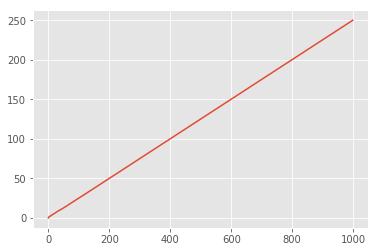

In [556]:
# experiment OneBitDist_log (MAP based on random one bit partition)

n=1000

np.random.seed(0)

Amax = 1
Amin = -1

j = 0
nMonte = 0
err = 0
nMonte += 100
sig = 1

m = np.sqrt(n) / np.sqrt(2*np.pi* np.log2(n))

n_vals = np.arange(n)
while j < nMonte :
    if j % 5 == 1 :
        print("Iteration #{}".format(j+1))
    th = (Amax-Amin) * np.random.rand() + Amin
    th = -1.5
    x = np.sqrt(sig) * np.random.randn(n) + th  #samples
    #m = np.sqrt(n) / ( sig + 2**(-n))
    th_hat = OneBitDist_log(x, m, Amin,Amax)
    #th_hat = OneBitDist(x,n,m,Amin,Amax)
    #th_hat = OneBitThresholds_history(x,Amin,Amax)
    err += (th_hat - th) ** 2
    j+=1

normalization_sequence = 1./nMonte * (np.arange(n)) 
normalized_err = err * normalization_sequence 
plt.plot(normalized_err)

print("{}".format(normalized_err[-int(n/3):].mean()))


Conjecture: with $m = \sqrt{n}/ \sqrt{2 \pi \log_2(n) }$, normalized error $\epsilon_n * n \rightarrow (1-2/\pi)$

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


97.8315866636196


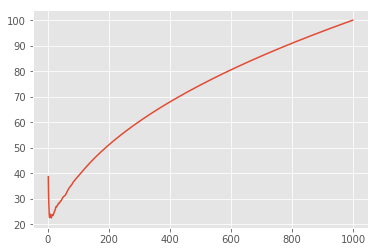

In [557]:
normalization_sequence = 1.*np.sqrt(np.arange(n)) / np.sqrt(2*np.pi*np.log2(np.arange(n)))

normalized_err = err * normalization_sequence 
plt.plot(normalized_err)

print("{}".format(normalized_err[-int(n/10.):].mean()))


25.343089204


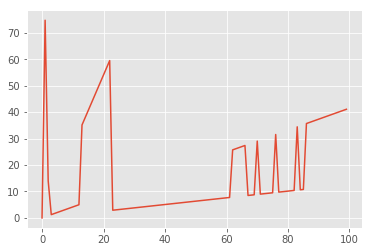

In [12]:
# experiment OneBitDist_count (most probable interval using random one bit partition)

def OneBitDist_count(x, m, Amin,Amax) :
    n = len(x)
    c = 2.*(np.random.rand(int(n),int(m))>0.5)-1

    yn = np.floor((x-Amin)/(Amax-Amin)*m)
    
    yn[yn<0]=0 #if y exceeds the interval (Amin,Amx) then the endpoints are reported
    yn[yn>=int(m)]=int(m)-1

    th_hat = np.zeros(n)
    acc = np.zeros(m)
    for i in range(n) :
        M = c[i,int(yn[i])] #one-bit messages
        acc += M*c[i]+(1-M)*(1-c[i])
        t_r = np.argmax(acc)
        th_hat[i] = 1.0*t_r*(Amax-Amin)/m + Amin

    return th_hat



n=100
#np.random.seed(0)

m = int(np.sqrt(n))

Amax = 5
Amin = -5

j = 0
err = 0
nMonte = 1

n_vals = np.arange(n)
while j < nMonte :
    if j % 5 == 1 :
        print("Iteration #{}".format(j+1))
    th = 0.75 * ((Amax-Amin) * np.random.rand() + Amin)
    x = np.random.randn(n) + th
    th_hat = OneBitDist_count(x, m, Amin,Amax)
    #th_hat = OneBitDist(x,n,m,Amin,Amax)
    err += (th_hat - th) ** 2
    j+=1

normalization_sequence = 1./nMonte * np.arange(n) 

normalized_err = err * normalization_sequence 
plt.plot(normalized_err)

print(normalized_err[-30:].mean())


mmse_mode = 0.12295395362265739
mmse_median = 0.42729520029083273
mmse_mean = 0.25490200543598357
RE_mode = 52.51408220210933
RE_median = 182.49933907375063
RE_mean = 108.8695765573256
52.4716986335
182.352045759
107.903357657


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide


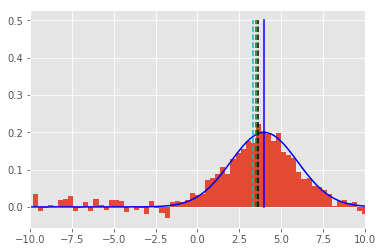

In [534]:

n = 50000
#mmse_lim = 1./n
m = int(np.sqrt(n / np.log(n)))
#m = int(np.sqrt(n))

Amax = 10
Amin = -10

def norm2real(x) :
    return (Amax-Amin) * x + Amin

def real2norm(x) :
    return (x-Amin) / (Amax-Amin)

th0 = np.random.rand()*0.5 + 0.25
th = norm2real(th0)
sig = 2

x = sig * np.random.randn(n) + th

n = len(x)
p_bin = 0.5
c = 2.*(np.random.rand(n,int(m))<p_bin)-1 #random partition of bins

bins_border, dx = np.linspace(Amin,Amax,m, retstep=True)
centers = bins_border + dx
dither = 0.5*dx * (np.random.rand(n)-0.5)
bins = np.argmin(np.abs(np.expand_dims(x + dither,0) - np.expand_dims(centers,1)),0)
#bins = np.round( real2norm(x)*(m + dither)) #bins where x falls

#if y exceeds the interval (Amin,Amx) then the endpoints are reported:
#bins[bins<0]=0 
#bins[bins>=int(m)]=int(m)-1

acc = np.zeros(m)
running_mean = np.zeros(n)
running_median = np.zeros(n)
running_mode = np.zeros(n)
acc_mean = 0

for i in range(n) :
    M = c[i,int(bins[i])] #one-bit messages (M in {-1,1})
    acc_mean += np.sum(M * c[i] * (centers - dither[i]))
    acc += M * c[i] 
    
    running_mean[i] = acc_mean / n
    running_mode[i] = centers[np.argmax(acc)]
    running_median[i] = centers[np.cumsum(acc) / n <=0.5][-1]

mean = np.sum(acc * centers ) / n
mode = centers[np.argmax(acc)]
median = centers[np.cumsum(acc) / n <=0.5][-1]

mmse_mode = (mode - th) ** 2
mmse_mean = (mean - th) ** 2
mmse_median = (median - th) ** 2

plt.bar(centers, acc / n / dx, width = dx )
plt.plot([th, th],[0,0.5],'b')

plt.xlim([Amin,Amax])
xx = np.linspace(Amin,Amax,100)
plt.plot(xx,phi((xx-th)/sig)/sig,'b')

plt.plot([mode, mode],[0,0.5],'--k')
plt.plot([mean, mean],[0,0.5],'--g')
plt.plot([median, median],[0,0.5],'--c')

print('mmse_mode = {}'.format(mmse_mode))
print('mmse_median = {}'.format(mmse_median))
print('mmse_mean = {}'.format(mmse_mean))
print('RE_mode = {}'.format(mmse_mode * n / np.log(n) ** 2 ))
print('RE_median = {}'.format(mmse_median * n / np.log(n) ** 2  ))
print('RE_mean = {}'.format(mmse_mean * n / np.log(n) ** 2 ))


nn = np.arange(1,n+1)
norm_seq = np.sqrt(nn) / np.log(nn)
k = 100

print( (((running_mode-th)*norm_seq )**2)[-k:].mean())
print( (((running_median-th)*norm_seq )**2)[-k:].mean())
print( (((running_mean-th)*norm_seq )**2)[-k:].mean())

In [532]:
((running_mean-th)*norm_seq)[-k:].var()

2.8698472624220659e-05

To Do: 
- Validate $Prob(T_{i,j}) \sim \int_{I_j}f(x-\theta)dx$
- Evaluate $var(T_{i,j})$ and $var(\sum_{i=1}^n T_{i,j})$
- analyze probabilit of error <br>

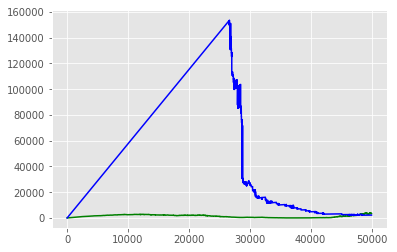

In [504]:

nn = np.arange(1,n+1) / np.log(n)
plt.plot((running_mean-th)**2 * nn,'g')
plt.plot((running_median-th)**2 * nn,'b')
#plt.plot((running_mode-th)**2 * nn,'r')

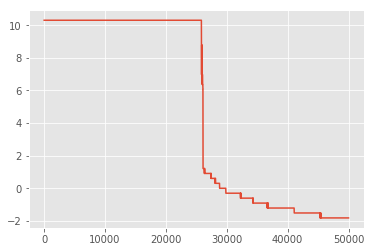

In [495]:
plt.plot(running_median)

In [ ]:
#exp OneBitDist_count


n=100
#np.random.seed(0)

m = int(11)

Amax = 5
Amin = -5

j = 0
err = 0
nMonte = 10

n_vals = np.arange(n)

th = 0.8*((Amax-Amin) * np.random.rand() + Amin)
x = np.random.randn(n) + th

c = 2.*(np.random.rand(int(n),int(m))>0.5)-1

dither = 10 * np.random.rand()/m

yn = np.floor(m*(x + dither - Amin)/(Amax-Amin) + 0.5)

yn[yn<0]=0
yn[yn>=int(m)]=int(m)-1

th_hat = np.zeros(n)
acc = np.zeros(m)
for i in xrange(n) :
    M = c[i,int(yn[i])] #one-bit messages
    acc += M*c[i]+(1-M)*(1-c[i])
    t_r = np.argmax(acc)
    th_hat[i] = 1.0* (t_r) *(Amax-Amin)/m + Amin - dither

print (th_hat[-1]-th) ** 2
print (th_hat[-1]-th)**2 * n

xx = np.linspace(Amin,Amax,len(acc))
plt.plot(xx,acc,'b')
plt.plot([th_hat[-1], th_hat[-1]], [min(acc),max(acc)],'--r')
plt.plot([th, th], [min(acc),max(acc)],'-r')

In [ ]:
def OneBitDist_count(x, m, Amin,Amax) :
    n = len(x)
    c = 2.*(np.random.rand(int(n),int(m))>0.5)-1

    yn = np.floor((x-Amin)/(Amax-Amin)*m)
    
    yn[yn<0]=0
    yn[yn>=int(m)]=int(m)-1

    th_hat = np.zeros(n)
    acc = np.zeros(m)
    for i in xrange(n) :
        M = c[i,int(yn[i])] #one-bit messages
        acc += M*c[i]+(1-M)*(1-c[i])
        t_r = np.argmax(acc)
        th_hat[i] = 1.0*t_r*(Amax-Amin)/m + Amin

    return th_hat


In [438]:
#Verify LAN results and effeciency of ML estimator

from scipy.optimize import minimize_scalar
n = 10000
th = -1

Amin = 4
Amax = 4

tt, dt = np.linspace(Amin,Amax,n, retstep = True) #uniform threshold
tt = np.zeros_like(tt)  #mass distribution

nMonte = 100
err_c = np.zeros(nMonte)
for i in range(nMonte) :
    x = np.random.randn(n) + th

    n = len(x)

    M = (x < tt)+0.0 #one bit messages

    #log-likelihood function
    
    def LL(u) : 
        return -(M * np.log(Phi(tt-u) + 1e-12 ) + (1-M) * np.log(Phi(u-tt) + 1e-12)).sum(0) 
    
    th_hat =  minimize_scalar(LL ,bounds = (Amin,Amax)).x
    err = th-th_hat
    err_c[i] = err

M = 2*M-1
num = np.sum( M*phi(M*(tt-th)) / (Phi(M*(tt-th)) ) ) / np.sqrt(n)
den = np.sum( phi(M*(tt-th)) ** 2 / Phi(M*(tt-th)) ** 2 ) / n
print ("num = {}".format(num))
print ("den = {}".format(den))
print ("I = {}".format(num/den))
print ("err = {}".format(np.sqrt(n)*err))

c = np.sum(phi(tt-th) ** 2 /(Phi(tt-th) * Phi(th - tt))) / len(tt)
print ("den / c = {}".format(den / c))
print ("c = {}".format(c))
print ("err**2 * n * c = {}".format(err_c.var() * n * c)) #should be 1


num = -0.08062068744569877
den = 0.4396265705726671
I = -0.18338447410191908
err = -0.18363248520814057
den / c = 1.0022746097189
c = 0.438628861102214
err**2 * n * c = 1.1966025874226591


(0, 3)

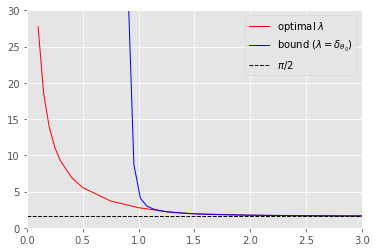

In [6]:
#plot threshold detection err, Gaussain prior

eta = lambda x: phi(x) ** 2 / (Phi(x) * Phi(-x) + 1e-9) + 1e-9
from scipy.integrate import quad as integral

sig = 1.
b = 1.

Amin = -7
Amax = 7

St = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3]
tr = [27.7328,18.4889,13.8669,11.0937,9.2449,6.9339,5.5472,3.6984,2.7739,2.2200,1.9303,1.7408,1.6725,1.6390]

SS = np.linspace(0.9, 3, 37)
val = np.zeros_like(SS)
for i,sig in enumerate(SS) :
    val[i] = integral(lambda t : phi(t * sig) * sig / eta(t) ,Amin/sig , Amax/sig )[0]

plt.plot(St,tr,'r',linewidth = 1)
plt.plot(SS / b,val,'b',linewidth = 1)
plt.plot(np.ones_like(SS) * np.pi/2, '--k', linewidth = 1)
plt.legend([r'optimal $\lambda$', r'bound ($\lambda = \delta_{\theta_0}$)',r'$\pi/2$'])

plt.ylim([0,30])
plt.xlim([0,3])
#plt.show()
#plt.savefig('dist_bound_Gauss_prior.png', format='png')

(0, 3)

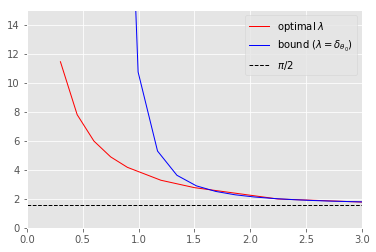

In [9]:
#plot expected threshold detection err, uniform prior
eta = lambda x: phi(x) ** 2 / (Phi(x) * Phi(-x) + 1e-9) + 1e-9
from scipy.integrate import quad as integral

b = 1.

Amin = -7
Amax = 7

St = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3])
tr = [11.4545,7.8029,5.9843,4.8923,4.1716,3.2810,2.7715,1.9862,1.7767,1.6941,1.6544,1.6125,1.5939,1.5852]

b = 1
pth = lambda x : (np.abs(x)<b) / (2.*b)

SS = np.linspace(0.1, 3, 51)
val = np.zeros_like(SS)
for i,sig in enumerate(SS) : #compute bound
    val[i] = integral(lambda t : pth(t) / eta(t / sig) ,-min(4*sig,b) , min(4*sig,b))[0]

plt.plot(St / (b ** 2 / 3),tr,'r',linewidth = 1)
plt.plot(SS / (b ** 2 / 3),val,'b',linewidth = 1)
plt.plot(np.ones_like(SS) * np.pi/2, '--k', linewidth = 1)
plt.legend([r'optimal $\lambda$', r'bound ($\lambda = \delta_{\theta_0}$)',r'$\pi/2$'])

plt.ylim([0,15])
plt.xlim([0,3])
#plt.show()

#plt.savefig('dist_bound_uniform_prior.png', format='png')

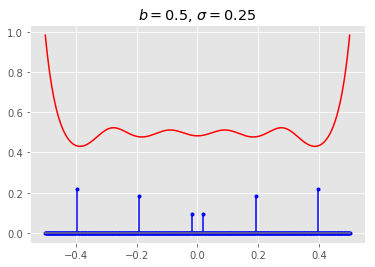

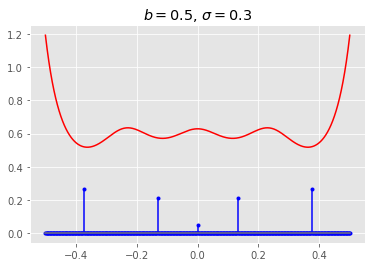

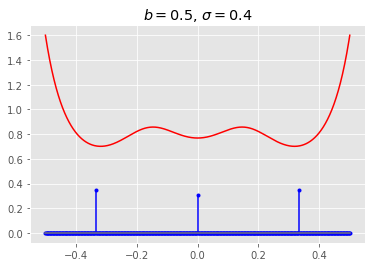

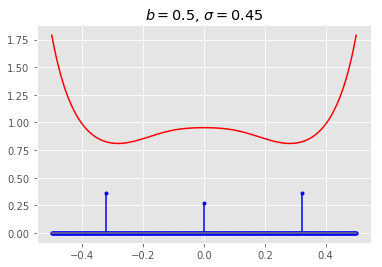

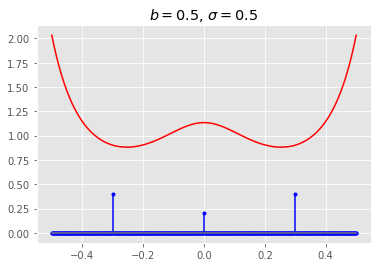

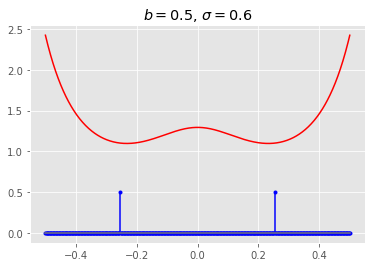

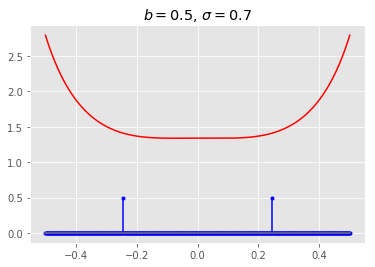

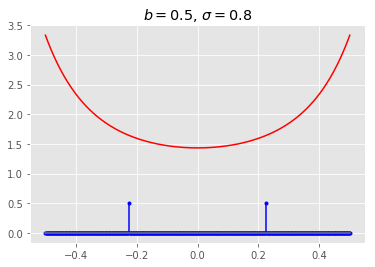

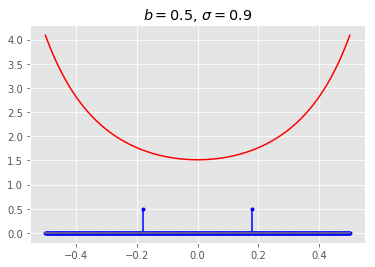

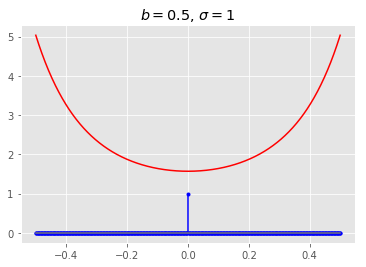

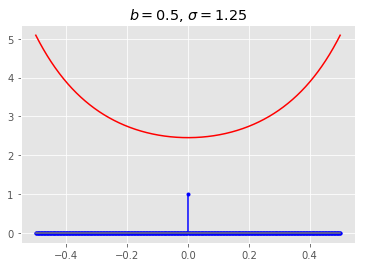

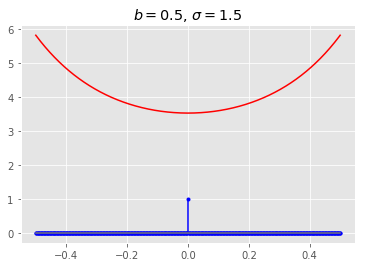

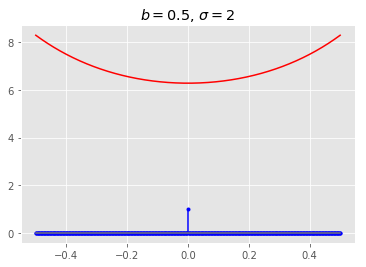

In [166]:
#optimal desnity for Bayes risk (uniform prior)
import cvxpy as cvx
import numpy as np
from scipy.integrate import quad as integral

eta = lambda x: phi(x) ** 2 / (Phi(x) * Phi(-x) + 1e-30) + 1e-30

BB = [0.5]
SSig = [0.25,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1,1.25,1.5,2]
#SSig = [0.25]

Kopt = np.zeros((len(BB),len(SSig)))
Kbound = np.zeros((len(BB),len(SSig)))

for j,b in enumerate(BB) :
    for i,sig in enumerate(SSig) :
        
        N_theta = 713
        N_thresh = 511

        th_max = b;
        theta_vals, dth = np.linspace(-th_max,th_max,N_theta,retstep=True);

        thr_max = th_max;
        thresh_vals, dhr = np.linspace(-thr_max,thr_max,N_thresh, retstep=True);

        [THR,TH] = np.meshgrid(thresh_vals, theta_vals);
        delta = ((THR - TH) / (sig/(2*np.sqrt(3))));
        G = eta(delta); # eta(t-th)/pi(th)

        # Construct the problem.
        x = cvx.Variable(N_thresh)
        A = cvx.Parameter(N_theta,N_thresh, sign="positive", value = G)

        objective = cvx.Minimize(cvx.sum_entries(cvx.inv_pos(A * x)) / N_theta)
        constraints = [0 <= x, cvx.sum_entries(x)<=1 ]
        prob = cvx.Problem(objective, constraints)

        # The optimal objective is returned by prob.solve().
        result = prob.solve()

        opt_R = np.sum(1/np.matmul(G,x.value))
        bound_R = np.mean(1/eta(thresh_vals/(sig/(2*np.sqrt(3)))))
        
        opt_lmd = x.value
        for t in range(len(opt_lmd)-1) :
            if opt_lmd[t] < opt_lmd[t+1] :
                opt_lmd[t+1] += opt_lmd[t]
                opt_lmd[t] = 0
            elif opt_lmd[t] > opt_lmd[t+1] :
                opt_lmd[t] += opt_lmd[t+1]
                opt_lmd[t+1] = 0
            if opt_lmd[t] < 0.001 :
                opt_lmd[t] = 0
                
        
        plt.stem(thresh_vals, np.array(opt_lmd),'b', markerfmt='b.')
        plt.plot(theta_vals, sig ** 2 / np.matmul(G,x.value),'r')
        plt.title(r"$b = {}$, $\sigma = {}$".format(b,sig))
        plt.show()
        Kopt[j][i] = prob.objective.value
        Kbound[j][i] = bound_R
        
        #write_to_csv(thresh_vals, np.squeeze(np.array(opt_lmd)), filename='unif_Bayes_lmd_b{}_sig{}.csv'.format(b,sig))
        #write_to_csv(theta_vals, 1 / np.squeeze(np.matmul(G,x.value).tolist()), filename='unif_Bayes_th_b{}_sig{}.csv'.format(b,sig))

write_to_csv(np.array(SSig), Kopt[0], filename='unif_Bayes_Risk.csv')


#import csv
#filename = 'unif_Bayes_Risk.csv'

#with open(filename,'w') as csvfile :
#    fieldnames = ["x", "Runif","Rbound"]
#    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#    writer.writeheader()
#    for xx,y,z in zip(np.array(SSig),Kopt[0],Kbound[0]) :
#        writer.writerow({"x" : xx, "Runif" : y, "Rbound" : z})



In [140]:
prob.objective.value

8.177295254444422

In [137]:
np.mean(1/np.matmul(G,x.value))

8.177295254444422

In [141]:
np.mean( 1/eta(thresh_vals/( sig/(2*np.sqrt(3)) )) )

223042938.16547254

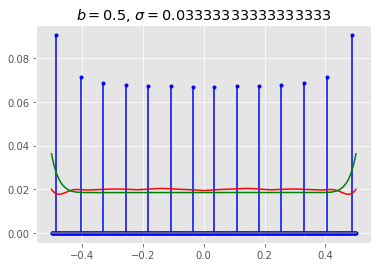

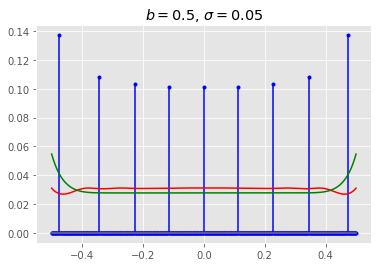

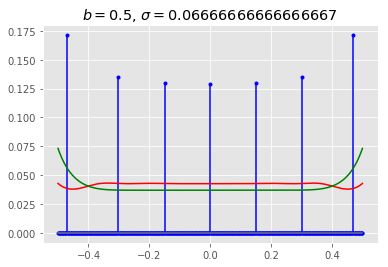

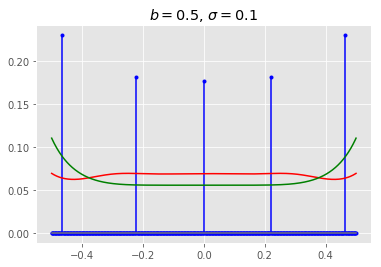

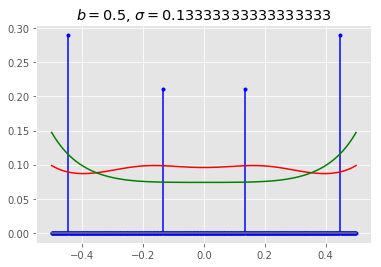

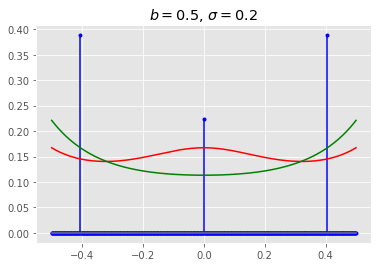

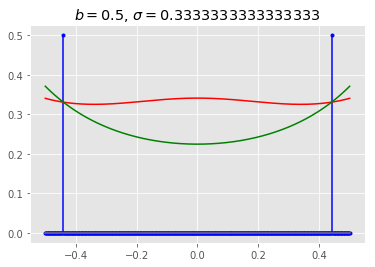

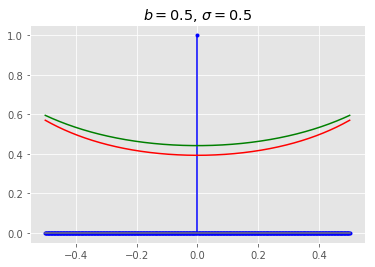

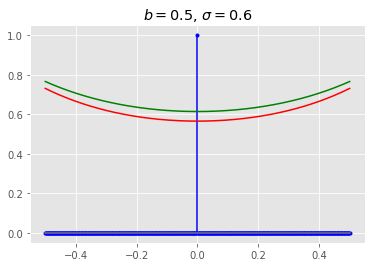

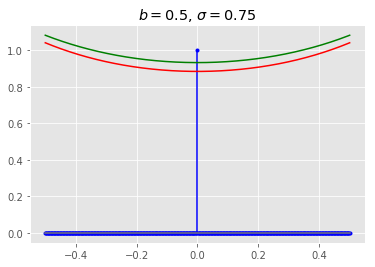

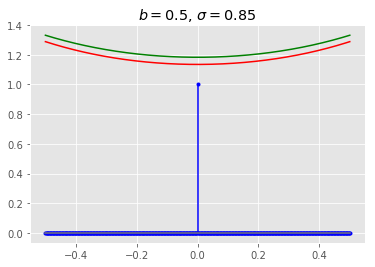

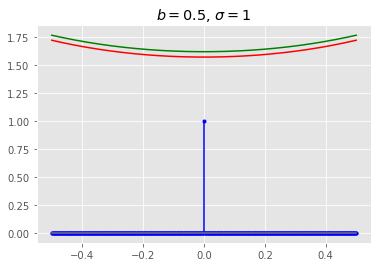

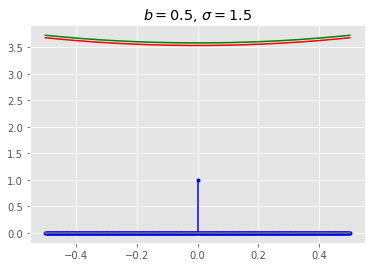

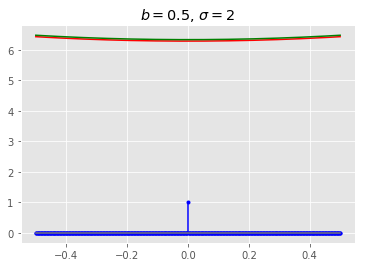

In [293]:
#optimal desnity for Bayes risk (uniform prior)
import cvxpy as cvx
import numpy as np
from scipy.integrate import quad as integral

eta = lambda x: phi(x) ** 2 / (Phi(x) * Phi(-x) + 1e-30) + 1e-30  #normal distribution

BB = [0.5]
SSig = [1/30, 1/20, 1/10, 1/5, 1/2]
SSig = [1/30, 1/20,1/15 ,1/10, 1/7.5, 1/5, 1/3, 1/2,0.6,0.75, 0.85 ,1, 1.5, 2]

Kopt = np.zeros((len(BB),len(SSig)))
Kunif = np.zeros((len(BB),len(SSig)))

for j,b in enumerate(BB) :
    for i,sig in enumerate(SSig) :
        
        N_theta = 713
        N_thresh = 511

        th_max = b;
        theta_vals, dth = np.linspace(-th_max,th_max,N_theta,retstep=True);

        thr_max = th_max;
        thresh_vals, dhr = np.linspace(-thr_max,thr_max,N_thresh, retstep=True);

        [THR,TH] = np.meshgrid(thresh_vals, theta_vals);
        delta = (THR - TH) / sig;

        G = eta(delta) / sig**2 # division by sigma^2 to get eta for the normal dist.

        # Construct the problem.
        x = cvx.Variable(N_thresh)
        l = cvx.Variable(1)
        A = cvx.Parameter(N_theta,N_thresh, sign="positive", value = G)

        objective = cvx.Minimize(l)
        constraints = [0 <= x, cvx.sum_entries(x) == 1, -A*x <= l]
        prob = cvx.Problem(objective, constraints)

        # The optimal objective is returned by prob.solve().
        result = prob.solve()

        opt_R = 1/np.min(np.matmul(G,x.value)) 
        unif_x = np.ones(N_thresh) / N_thresh
        unif_R = 1/np.min(np.matmul(G,unif_x))
        
        opt_lmd = x.value
        for t in range(len(opt_lmd)-1) :
            if opt_lmd[t] < opt_lmd[t+1] :
                opt_lmd[t+1] += opt_lmd[t]
                opt_lmd[t] = 0
            elif opt_lmd[t] > opt_lmd[t+1] :
                opt_lmd[t] += opt_lmd[t+1]
                opt_lmd[t+1] = 0
            if opt_lmd[t] < 0.001 :
                opt_lmd[t] = 0
                
        
        opt_func = 1/np.matmul(G,x.value)
        unif_func = 1/np.matmul(G,unif_x)
        #write_to_csv(thresh_vals, np.squeeze(np.array(opt_lmd)), np.squeeze(np.array(opt_lmd)), filename='minmax_lmd_b{}_sig{}.csv'.format(b,sig))
        #write_to_csv(theta_vals, np.squeeze(opt_func.tolist()), np.squeeze(unif_func.tolist()), filename='minimax_th_b{}_sig{}.csv'.format(b,sig))
        
        plt.stem(thresh_vals,opt_lmd,'b', markerfmt='b.')
        plt.plot(theta_vals,1 / np.matmul(G,x.value),'r')
        plt.plot(theta_vals,1 / np.matmul(G,unif_x),'g')
        plt.title(r"$b = {}$, $\sigma = {}$".format(b,sig))
        plt.show()
        Kopt[j][i] = 1/opt_R
        Kunif[j][i] = 1/unif_R


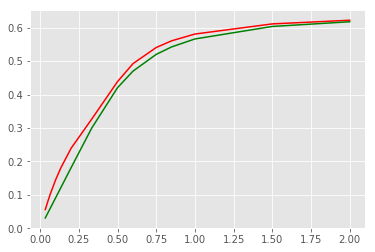

In [302]:
plt.plot(SSig, np.array(SSig)**2 * Kopt[0],'r')
plt.plot(SSig, np.array(SSig)**2 * Kunif[0],'g')

In [303]:
write_to_csv(SSig, np.array(SSig)**2 * Kopt[0], np.array(SSig)**2 * Kunif[0], filename='minmax_ARE_b{}_sig{}.csv'.format(b,sig))
        

In [367]:
def Kfunc(b,sig) :
    al = 2 * np.exp(-1)
    beta = np.pi/2
    return (al * (b / sig) + 1) * sig**2 * np.pi / 2


In [374]:
def Kfunc(b,sig) :
    al = 1. / 2
    beta = np.pi/2
    return (al * (2*b / sig) + beta) * sig**2



Function "Kfunc" works!

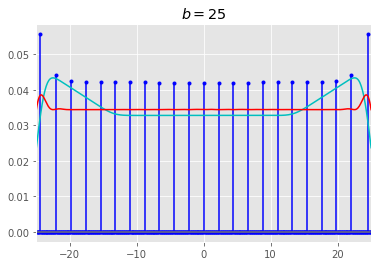

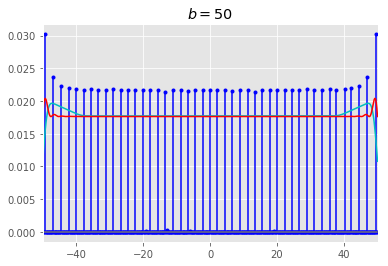

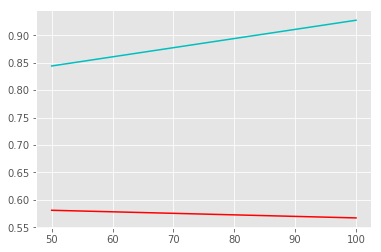

In [10]:
import cvxpy as cvx
import numpy as np
from scipy.integrate import quad as integral

eta = lambda x: phi(x) ** 2 / (Phi(x) * Phi(-x) + 1e-30) + 1e-30

BB = [25,50] #size of support
SSig = [1]

iKopt = np.zeros((len(BB),len(SSig)))
iKstar = np.zeros((len(BB),len(SSig)))
iKunif = np.zeros((len(BB),len(SSig)))
iKunif_int = np.zeros((len(BB),len(SSig)))

for j,b in enumerate(BB) :
    for i,sig in enumerate(SSig) :
        
        N_theta = 511
        N_thresh = 511

        th_max = b * sig;
        theta_vals, dth = np.linspace(-th_max,th_max,N_theta,retstep=True);

        #thr_max = sig*(b+2)
        thr_max = sig*b
        thresh_vals, dhr = np.linspace(-thr_max,thr_max,N_thresh, retstep=True);

        [THR,TH] = np.meshgrid(thresh_vals, theta_vals);
        delta = (THR - TH) / sig;
        #delta[delta>20] = 20; #limit of accuracy for eta(x)
        #delta[delta<-20] = -20;
        G = eta(delta) / sig ** 2;

        # Construct the problem.
        x = cvx.Variable(N_thresh)
        l = cvx.Variable(1)
        A = cvx.Parameter(N_theta,N_thresh, sign="positive", value = G)

        objective = cvx.Minimize(l)
        constraints = [0 <= x, cvx.sum_entries(x) == 1, -A*x <= l]
        prob = cvx.Problem(objective, constraints)

        # The optimal objective is returned by prob.solve().
        result = prob.solve()

        opt_R = 1/np.min(np.matmul(G,x.value)) # precision under optimal distribution
        unif_x = np.ones(N_thresh) / N_thresh  
        unif_R = 1/np.min(np.matmul(G,unif_x))  # precision under uniform threshold
        
        x_star = (1/(eta(THR-TH))**0.5).mean(1)
        x_star = x_star / x_star.sum()
        R_star = 1/np.min(np.matmul(G,x_star))
        
        xl = np.array(x.value[2:]+x.value[1:-1]+x.value[:-2])
        for l in range(len(xl)-2) :
            if (xl[l+1] >= xl[l]) :
                xl[l] = 0
            if (xl[l] >= xl[l+1]) :
                xl[l+1] = 0
            if (xl[l] >= xl[l+2]) :
                xl[l+2] = 0
        
        plt.stem(thresh_vals[1:-1] / sig, xl,'b', markerfmt='b.')
        plt.plot(thresh_vals / sig, np.matmul(G,x_star),'c')
        plt.plot(theta_vals / sig, np.matmul(G,x.value),'r', linewidth = 1.5)
        #plt.plot(theta_vals / sig, np.matmul(G,unif_x),'--g', linewidth = 1.5)
        plt.xlim([-b,b])
        plt.title(r"$b = {}$".format(b,sig))
        #plt.savefig("minimax_b_only{}.eps".format(b),format='eps')
        plt.show()
        iKopt[j][i] = opt_R
        iKunif[j][i] = unif_R
        iKunif_int[j][i] = 1/(0.5*integral(eta,-b,b)[0] / (2*b) )
        iKstar[j][i] = R_star

plt.plot(2*np.array(BB), iKopt.T[0] / BB / 2 ,'r', linewidth = 1.5)
plt.plot(2*np.array(BB), iKstar.T[0] / BB / 2 ,'c', linewidth = 1.5)

plt.show()


In [30]:
#compare discrete uniform with theoretic value

import cvxpy as cvx
import numpy as np
from scipy.integrate import quad as integral

eta = lambda x: phi(x) ** 2 / (Phi(x) * Phi(-x) + 1e-30) + 1e-30

BB = [0.5,1,2,3,5,7.5,10,20,30,40,50,70,85,100,150,200,300]
SSig = [1]

iKunif = np.zeros((len(BB),len(SSig)))

for j,b in enumerate(BB) :
    for i,sig in enumerate(SSig) :
        
        N_theta = 111
        N_thresh = 5712

        th_max = b * sig;
        theta_vals, dth = np.linspace(-th_max,th_max,N_theta,retstep=True);

        thr_max = sig * b
        thresh_vals, dhr = np.linspace(-thr_max,thr_max,N_thresh, retstep=True);

        [THR,TH] = np.meshgrid(thresh_vals, theta_vals);
        delta = (THR - TH) / sig;
        #delta[delta>20] = 20; #limit of accuracy for eta(x)
        #delta[delta<-20] = -20;
        G = eta(delta) / sig ** 2;
    
        unif_x = np.ones(N_thresh) / N_thresh
        unif_R = 1/np.min(np.matmul(G,unif_x)) #uniform risk

        iKunif[j][i] = unif_R

print("{}".format(iKunif.T[0] / BB / 2))
print("{}".format(1/integral(lambda x : eta(x-b),-b,b)[0]))
print("{}".format(1/integral(lambda x : eta(x),-b,b)[0]))

[ 1.76578698  1.18925649  1.10727058  1.10696183  1.10668875  1.1063476
  1.10600665  1.10464498  1.10328666  1.10193167  1.10058001  1.09788661
  1.09587519  1.09387113  1.08724356  1.0806958   1.06783408]
1.1071778181556808
0.553588909077838


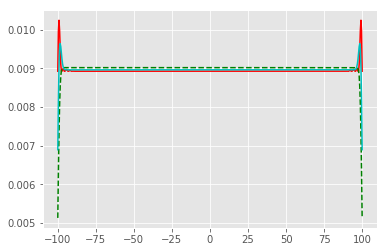

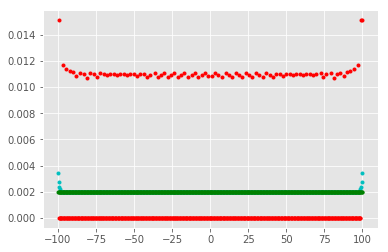

In [83]:
x_star = 1/(eta(THR-TH) ).mean(1)
x_star = x_star / x_star.sum()
#plt.stem(thresh_vals[1:-1] / sig,xl,'b', markerfmt='b.')
plt.plot(theta_vals / sig,np.matmul(G,x.value),'r', linewidth = 1.5)
plt.plot(theta_vals / sig,np.matmul(G,unif_x),'--g', linewidth = 1.5)
plt.plot(theta_vals / sig,np.matmul(G,x_star),'c')
plt.show()
plt.plot(theta_vals / sig,x_star,'.c')
plt.plot(theta_vals[1:-1] / sig,xl,'.r')
plt.plot(theta_vals / sig,unif_x,'.g')

The asymptotic distribution  (as $b\rightarrow \infty$) is (?)
$$
\lambda(dt) = \frac{dt}{\left(\int_{-b}^b \eta(t-s)ds \right)^{2}}.
$$
as a result, the asymptotic ML risk is (same as average risk with $\theta$ uniform)
$$
\frac{2b}{\int_{-b}^b \eta(s)ds}
$$

<br>
$$ 
\frac{1}{2b} \int \eta(t) \lambda(dt)$$ is a lower bound on effeciency (replace $\sup_{\tau}$ by a uniform distribution on $\tau$).


Show that support is discrete by using the fact that $\eta$ is concave between $\sim(-1.1,1.1)$, hence 
$$
\int \eta(x) \lambda(dx) \leq \eta \left(\int \lambda(dx)\right),
$$
Use this last fact to deduce that every continuous strategy is dominated by a discrete strategy. 

<H1> Distributed scheme that is independent of size of parameter space </H1>

Devide the interval $(-b,b)$ into $M$ intervals $I_1,\ldots,I_M$. (equi-distance if prior is uniform). The length of each unit is 
$$ d = \frac{2b}{\sqrt{n}} c_n $$,
so $M = 2b / d = c_n / \sqrt{n}$. If we can communicate $~\log_2(M)$ bits, then we can get distortion not exceeding $d/2$. 

For every $n$, $A_n$ is a set of the above intervals corresponding to a code that pins the location of $\theta \in (-b,b)$. Set $B_n = \mathbf 1(\theta \in A_n)$, so that $B_n$ is the a sequence of bits that is an error correction code for $\theta$. 

